In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import scienceplots

# Ensure the module is automatically reloaded when rerunning the import command.
# %load_ext autoreload
# %autoreload 2

In [28]:
def import_flowmeter(file_path, set_time_zero=True):
    # Load the data into a pandas dataframe
    flow_data = pd.read_csv(file_path, skiprows=1, names=['time', 'flow'])
    
    try:
        # Reverse the dataframe
        data_rev = flow_data.iloc[::-1]
        
        # Identify the final occurrence of a string containing letters in the 'time' column
        start_index = data_rev.loc[data_rev['time'].apply(
                lambda x: bool(re.search('[a-zA-Z]', x)))].first_valid_index()
        
        # Filter out any rows after this index
        flow_data = data_rev.loc[:(start_index + 1)].iloc[::-1]
    except: TypeError
    
    # Convert to floats
    flow_data = flow_data.astype(np.float64)
    
    # Get the nonzero flow values
    mask = flow_data['flow'] > 0
    
    # Make this mask slightly larger on each side
    mask = mask | mask.shift(1) | mask.shift(-1)
    
    # Set the time zero to the first time value
    if set_time_zero:
        flow_data['time'] = flow_data['time'] - flow_data['time'][mask].iloc[0]
    
    # Apply the mask
    return flow_data[mask]

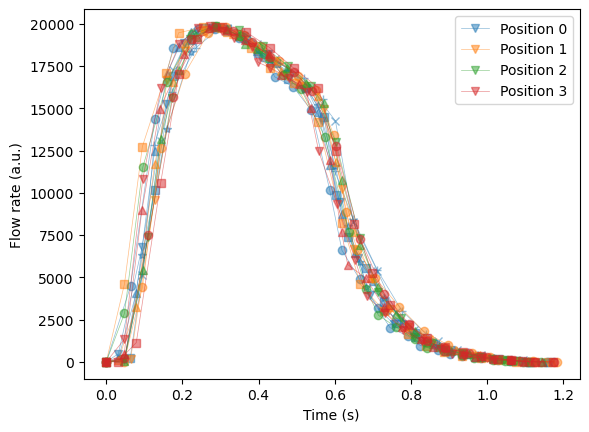

In [39]:
# Set the path to the flow meter data file
directory = 'data/flowmeter/'

# Get a list of all the files in the directory, filtering out hidden files
files = [file for file in os.listdir(directory) if not file.startswith('.')]

# Import the data from all files in the directory
data = [import_flowmeter(directory + file) for file in files]

# Split the dataset according to the position number in the file name
data = [[data[j] for j in range(len(data)) if f'pos{i}' in files[j]] 
        for i in range(1, 5)]

# Define a list of colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Define a list of marker styles
markers = ['o', 'v', '^', 's', '+', 'x', '*']

# Plot all data points, with separate colours for each position and symbols for each entry
fig, ax = plt.subplots()
for i in range(4):
    for j in range(len(data[i])):
        label = f'Position {i}' if j == 1 else '_' 
        ax.plot(data[i][j]['time'], data[i][j]['flow'], lw=0.5, alpha=0.5, 
                marker=markers[j], color=colors[i], label=label)
              
ax.set_xlabel('Time (s)')
ax.set_ylabel('Flow rate (a.u.)')
ax.legend()
plt.show()